In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd
from scipy import optimize
from scipy import stats
import csv

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

The function has 2 global minima in (x1,y1)=(-0.090,0.713) and (x2,y2)=(0.090,-0.713) and the value of the function is: -1.03163

When the initial guess is (0,0) the algorithm converges in a local minimum

       fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])


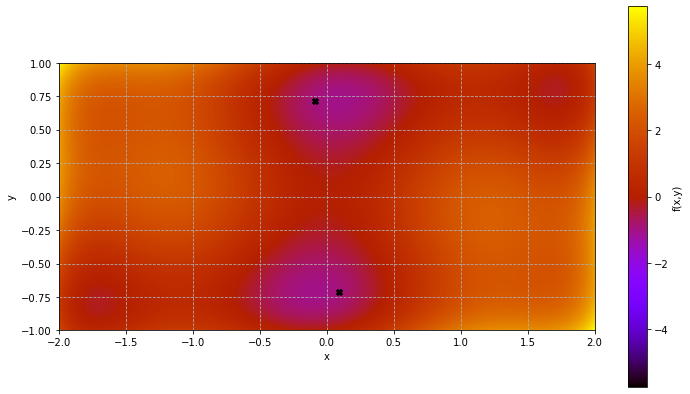

In [3]:
def fun(vec):
    x=vec[0]
    y=vec[1]
    f=(4-2.1*x**2+(x**4)/3)*x**2+x*y+(4*y**2-4)*y**2
    return f


x=np.linspace(-2,2,1000)
y=np.linspace(-1,1,1000)



X,Y=np.meshgrid(x,y)
Z=fun([X,Y])
Zmin, Zmax = -np.abs(Z).max(), np.abs(Z).max()

fig,ax=plt.subplots(figsize=(12,7))

c=ax.imshow(Z, cmap ='gnuplot', vmin = Zmin, vmax = Zmax,
                 extent =[X.min(), X.max(), Y.min(), Y.max()])
cbar=plt.colorbar(c)
cbar.set_label("f(x,y)")
ax.set_xlabel("x")
ax.set_ylabel("y")

#1
minim1=optimize.minimize(fun, x0=[0,0.7])
minim2=optimize.minimize(fun, x0=[0,-0.7])
#2
if np.allclose(minim1["fun"], minim2["fun"]):
    print("The function has 2 global minima in (x1,y1)=({:.3f},{:.3f}) and (x2,y2)=({:.3f},{:.3f}) and the value of the function is: {:.5f}\n".format(minim1['x'][0], minim1['x'][1], minim2['x'][0], minim2['x'][1], minim1["fun"]))
#3
print("When the initial guess is (0,0) the algorithm converges in a local minimum")
minim0=optimize.minimize(fun, x0=[0,0])
print("\n",minim0)

ax.scatter(minim1['x'][0], minim1['x'][1], marker="X", c='black')
ax.scatter(minim2['x'][0], minim2['x'][1], marker="X", c='black')
ax.grid(linestyle='--')



2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

For maximum temperatures: 

parameters:
 [10.58169955  6.72277483 27.94963524  0.09426337]
covariance matrix:
 [[ 1.68164704e-01  9.22468415e-04  6.55153578e-03 -1.36700861e-04]
 [ 9.22468415e-04  5.14156302e-03 -1.69803536e-03 -1.44974615e-05]
 [ 6.55153578e-03 -1.69803536e-03  1.83399111e-01  1.01904073e-03]
 [-1.36700861e-04 -1.44974615e-05  1.01904073e-03  1.13662419e-05]]
A = 10.6 +- 0.4
o = 6.7 +- 0.1
c = 27.9 +- 0.4
f = 0.094 +- 0.003 

For minimum temperatures: 

parameters:
 [ 25.14962021   7.13299513 -36.7125686    0.09570318]
covariance matrix:
 [[ 1.72807287e+00  9.03802303e-03  1.89189110e-01 -3.94968602e-05]
 [ 9.03802303e-03  9.05143291e-03 -1.65323766e-02 -5.98038244e-05]
 [ 1.89189110e-01 -1.65323766e-02  1.41860159e+00  2.54653480e-03]
 [-3.94968602e-05 -5.98038244e-05  2.54653480e-03  1.34431890e-05]]
A = 25 +- 1
o = 7.1 +- 0.1
c = -37 +- 1
f = 0.096 +- 0.004

Compatibility of the offsets: 3.4


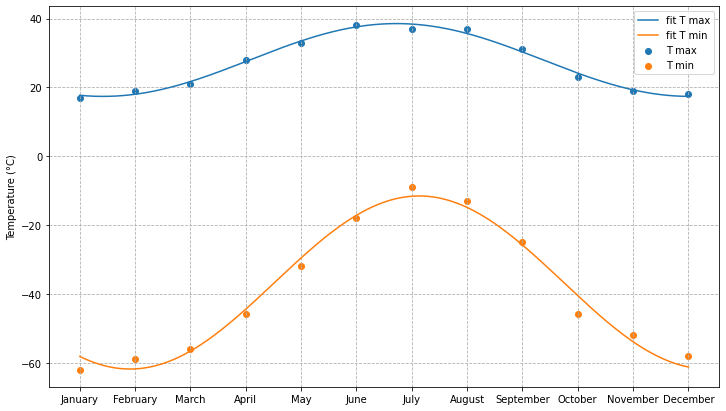

In [3]:
import calendar

months = [x for x in calendar.month_name[1:]]
m=np.arange(1,13,1)
Tmax=[17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
Tmin=[-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

#1
fig, ax=plt.subplots(figsize=(12,7))
ax.grid(linestyle='--')
ax.scatter(m, Tmax, label="T max")
ax.scatter(m, Tmin, label="T min")
ax.set_ylabel("Temperature (°C)")
plt.xticks(m, months)

#2
def f(x, A, o, c,f):
    f=A*np.cos(2*math.pi*f*(x-o))+c
    #f=a*x**2+b*x+c
    return f

#3
print("For maximum temperatures: \n")
Mp, Mpcov = optimize.curve_fit(f, m, Tmax, p0=[10,7,20,1/11])#, full_output=False)
print("parameters:\n", Mp)
print("covariance matrix:\n", Mpcov)
print("A = %.1f +- %.1f" % (Mp[0], np.sqrt(Mpcov[0,0])))
print("o = %.1f +- %.1f" % (Mp[1], np.sqrt(Mpcov[1,1])))
print("c = %.1f +- %.1f" % (Mp[2], np.sqrt(Mpcov[2,2])))
print("f = %.3f +- %.3f \n" % (Mp[3], np.sqrt(Mpcov[3,3])))

print("For minimum temperatures: \n")
mp, mpcov = optimize.curve_fit(f, m, Tmin, p0=[30,7,-40,1/12])#, full_output=False)
print("parameters:\n", mp)
print("covariance matrix:\n", mpcov)
print("A = %.0f +- %.0f" % (mp[0], np.sqrt(mpcov[0,0])))
print("o = %.1f +- %.1f" % (mp[1], np.sqrt(mpcov[1,1])))
print("c = %.0f +- %.0f" % (mp[2], np.sqrt(mpcov[2,2])))
print("f = %.3f +- %.3f" % (mp[3], np.sqrt(mpcov[3,3])))

#4
X=np.linspace(1,12,1000)
ax.plot(X,f(X, Mp[0], Mp[1], Mp[2], Mp[3]), label="fit T max")
ax.plot(X,f(X, mp[0], mp[1], mp[2], mp[3]), label="fit T min")
ax.legend()

#How to consider the fit without the errors of the data???

#5
comp=abs(Mp[1]-mp[1])/math.sqrt(mpcov[1,1]+Mpcov[1,1])
print("\nCompatibility of the offsets: {:.1f}".format(comp))   #va bene la compatibilità?

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [4]:
#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P ~/data/

parameters:
 [ 6.98066584e+02 -9.30442509e-02  2.67393830e-01]
covariance matrix:
 [[ 1.48698578e+03  6.08433680e-03 -2.39328368e-01]
 [ 6.08433680e-03  1.26749214e-04 -2.30967291e-06]
 [-2.39328368e-01 -2.30967291e-06  9.17506166e-05]]
A = 7.0e+02 +- 4e+01
m = -0.09 +- 0.01
s = 0.27 +- 0.01
chi2 = 695.8
p-value = 0.0


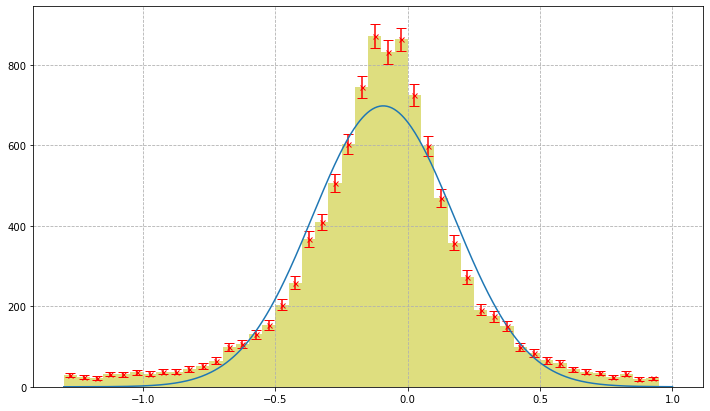

In [5]:
file_name="~/data/residuals_261.pkl"
data=pd.read_pickle(file_name).item()
data=pd.DataFrame(data)

#1
fig, ax=plt.subplots(figsize=(12,7))
binsarr=np.arange(-1.3,1,0.05)   #non consideriamo molto valori esagerati???
histo=ax.hist(data['residuals'],bins=binsarr,alpha=0.5, color='y')
ax.grid(ls='--')

#2
n=histo[0]
p=histo[1][1]-histo[1][0]
b=[i+p/2 for i in histo[1][:-1]]
n_err=[math.sqrt(i) for i in n]
ax.errorbar(b, n, yerr=n_err, fmt='x', ms=5, c='r', capsize=5)

#3
def gauss(x, A, m, s):
    return A*np.exp(-(x-m)**2/(2*s**2))


par, pcov = optimize.curve_fit(gauss, b, n, p0=[3000,-0.1,0.5], sigma=n_err)
print("parameters:\n", par)
print("covariance matrix:\n", pcov)
print("A = %.1e +- %.0e" % (par[0], np.sqrt(pcov[0,0])))
print("m = %.2f +- %.2f" % (par[1], np.sqrt(pcov[1,1])))
print("s = %.2f +- %.2f" % (par[2], np.sqrt(pcov[2,2])))

X=np.linspace(-1.3,1,500)
ax.plot(X, gauss(X, par[0], par[1], par[2]))


#4

chi2 = np.sum(((n - gauss(b, par[0], par[1], par[2]))**2)/n_err / n_err)
print("chi2 = {:.1f}".format(chi2))
ndof=len(b)-1  #è giusto??
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue)  #Non è accettabile??

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [6]:
#!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -P ~/data/

Best fit values of the parameters for f(x): 

a = -10.00 +- 0.12
b = 12.32 +- 0.01
c = 9.25 +- 0.09

The overall average temperature in Munich is: 9.25 ± 0.09

The typical daily average values predicted by the model for the coldest time of year is: 19.25 ± 0.15
The typical daily average values predicted by the model for the hottest time of year is: -0.74 ± 0.15

The parameter b has no physical meaning, it is just an horizontal transition of the cosine function.

Best fit values of the parameters for g(x): 

a = -10.00 +- 0.12
b = 0.999 +- 0.001
c = 24 +- 17
d = 9.24 +- 0.09

RSS for f(x) is: 24678.63
RSS for g(x) is: 24672.38

Test f(x) vs g(x):
CL: 0.497 , additional parameter necessary: NO


<ipython-input-7-eec43e5a7b1a>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[data['days']>2008][data['days']<2013]


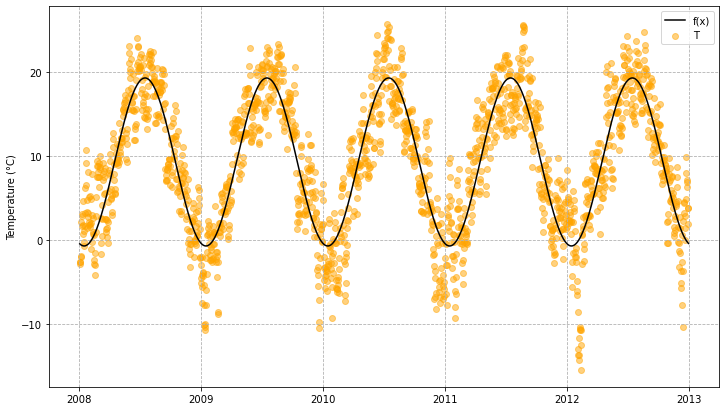

In [7]:
file_name='/home/eugenio/data/munich_temperatures_average_with_bad_data.txt'
data=pd.read_csv(file_name,sep=' ', header=None, names=['days', 'T'])
#remove improbable data
data=data[abs(data['T'])<90]
data=data[data['days']>2008][data['days']<2013]

days=data['days']
T=data['T']

#1
fig, ax=plt.subplots(figsize=(12,7))
ax.grid(linestyle='--')
ax.scatter(days, T, label="T", alpha=0.5, c='orange')
ax.set_ylabel("Temperature (°C)")
ax.set_xticks(np.arange(1994,2015,1))

def f(x, a,b,c):
    f=a*np.cos(2*math.pi*x+b)+c
    return f

par, pcov = optimize.curve_fit(f, days, T)
print("Best fit values of the parameters for f(x): \n")
print("a = %.2f +- %.2f" % (par[0], np.sqrt(pcov[0,0])))
print("b = %.2f +- %.2f" % (par[1], np.sqrt(pcov[1,1])))
print("c = %.2f +- %.2f" % (par[2], np.sqrt(pcov[2,2])))



X=np.linspace(days.min(),days.max(),20000)
ax.plot(X, f(X, par[0], par[1], par[2]), c='black', label="f(x)")
ax.legend()


print("\nThe overall average temperature in Munich is: {:.2f} \u00B1 {:.2f}\n".format(par[2], np.sqrt(pcov[2,2])))


Mext=par[2]+abs(par[0])
mext=par[2]-abs(par[0])
Mext_err=math.sqrt(pcov[0,0]+pcov[2,2]-2*pcov[0,2])
mext_err=math.sqrt(pcov[0,0]+pcov[2,2]+2*pcov[0,2])

print("The typical daily average values predicted by the model for the coldest time of year is: {:.2f} \u00B1 {:.2f}".format(Mext, Mext_err))
print("The typical daily average values predicted by the model for the hottest time of year is: {:.2f} \u00B1 {:.2f}\n".format(mext, mext_err))

print("The parameter b has no physical meaning, it is just an horizontal transition of the cosine function.")

#2

def g(x, a,b,c,d):
    g=a*np.cos(2*math.pi*b*x+c)+d
    return g

Par, Pcov = optimize.curve_fit(g, days, T)
print("\nBest fit values of the parameters for g(x): \n")
print("a = %.2f +- %.2f" % (Par[0], np.sqrt(Pcov[0,0])))
print("b = %.3f +- %.3f" % (Par[1], np.sqrt(Pcov[1,1])))
print("c = %.0f +- %.0f" % (Par[2], np.sqrt(Pcov[2,2])))
print("d = %.2f +- %.2f" % (Par[3], np.sqrt(Pcov[3,3])))

#ax.plot(X, g(X, Par[0], Par[1], Par[2], Par[3]), c='red', label="g(x)")


ssr = np.sum((T-f(days, par[0], par[1], par[2]))**2)
Ssr = np.sum((T-g(days, Par[0], Par[1], Par[2], Par[3]))**2)
ndof=3-1
Ndof=4-1
N=len(T)

print("\nRSS for f(x) is: {:.2f}". format(ssr))
print("RSS for g(x) is: {:.2f}". format(Ssr))

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

print("\nTest f(x) vs g(x):")
cl_1_vs_2 = Ftest(ssr, Ssr, ndof, Ndof, N, verbose=True)